# 四、手撕位置编码

## 1. 绝对位置编码（APE）
> 出处：[Attention Is All You Need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) (2017)

绝对位置编码(Absolute Position Encoding)是一种为序列数据添加位置信息的方法。它通过为输入序列中的每个元素赋予一个独特的位置表示，使模型能够感知序列中元素的空间位置关系。

- 位置编码值**仅取决于元素在序列中的位置，与输入数据的具体内容完全无关**
- 编码通常由预定义的数学函数生成，无需通过训练学习，最常见的实现方式是正弦和余弦
- 使用sin和cos实现的优势：
  - sin和cos具有良好的周期特性，能自然地表达序列中的循环模式
  - 可以有效捕获元素间的相对位置关系
  - 不同频率的三角函数组合可以产生独特的位置指纹

公式：$$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$ $$PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$

- $PE(pos, i)$ 表示位置 $pos$ 的位置编码向量中的第 $i$ 维。
- $d_{model}$ 是模型的维度（即词嵌入的维度）。

位置编码矩阵热力图:

- 横轴（Dimension）：编码维度 $i$，从第 0 维到第 $d_{model}-1$ 维；  
- 纵轴（Position）：序列位置 $pos$，从第 0 个位置到第 $max\_len-1$ 个位置；  

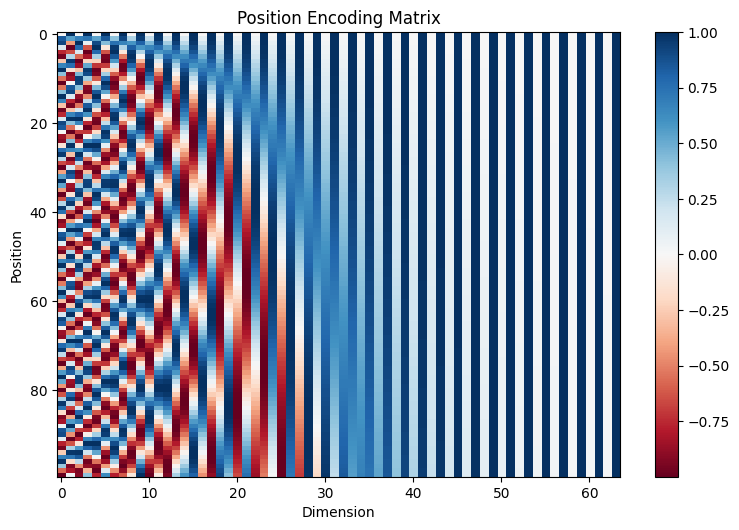

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def get_position_encoding(max_len, d_model):
    pe = np.zeros((max_len, d_model))
    position = np.arange(max_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

max_len = 100  # 序列长度
d_model = 64   # 编码维度

pe = get_position_encoding(max_len, d_model)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(pe, aspect='auto', cmap='RdBu')
plt.colorbar()
plt.title('Position Encoding Matrix')
plt.xlabel('Dimension')
plt.ylabel('Position')

plt.tight_layout()
plt.show()

从图中可以观察到：

- 正弦/余弦交替  
  - 偶数维（0,2,4…）对应该位置的 $\sin$ 值，呈现正弦曲线形状；  
  - 奇数维（1,3,5…）对应该位置的 $\cos$ 值，呈现余弦曲线形状；  
  - 相邻的偶/奇列波峰波谷错开 90°，红蓝相间。

- 频率随着维度增大而减小
  - 角频率 $\omega_i=\frac{1}{10000^{\frac{2i}{d_{model}}}}\rightarrow T=\frac{2\pi}{\omega_i}=2\pi\cdot10000^{\frac{2i}{d_{model}}}$，$i$越大，周期$T$越大，频率$f$越小
  - 因此编码维度$i$越小，频率越高，红蓝带翻转越快（如热力图左侧所示）；编码维度$i$越大，频率越低，红蓝带翻转越慢（如热力图右侧所示）
  - 说明不同维度编码捕获了从低频到高频的多尺度位置信息。

- 位置唯一指纹: 任意一个 $pos$ 纵向看，其在所有维度上的颜色组合在高维空间中是唯一的

APE的实现 和 在Multi Head Attention中的应用：

- 主流实现方式：使用exp-log$$\frac{1}{10000^{\frac{2i}{d_{model}}}}=e^{-\ln(10000)\cdot\frac{2i}{d_{model}}}$$数值上更稳定
- 在计算Q、K、V前为输入 x 添加 position embedding

In [14]:
import torch
from torch import nn
import math

# APE实现一：通过exp和log进行更稳定的数值计算
class AbsolutePositionEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_len):
        super().__init__()
        # 算序列位置pos
        pos = torch.arange(max_seq_len).unsqueeze(1)        # shape: [seq_len, 1]
        # 算编码位置2i
        dim_pos = torch.arange(0, d_model, 2).unsqueeze(0)  # shape: [1, dim / 2]
        # 根据dim_pos和pos算angle
        div_term = torch.exp(-math.log(10000) * dim_pos.float() / d_model) # shape: [1, dim / 2]
        angle = pos * div_term                              # shape: [seq_len, dim / 2]
        # 初始化pe
        pe = torch.zeros(max_seq_len, d_model)              # shape: [seq_len, dim]
        pe[:, 0::2] = torch.sin(angle)                      # 偶数维对应sin值
        pe[:, 1::2] = torch.cos(angle)                      # 奇数维对应cos值
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        return self.pe[:x.size(1)]  # 返回对应长度的位置编码

# APE实现二：直接根据公式实现
class AbsolutePositionEmbedding_(nn.Module):
    def __init__(self, d_model, max_seq_len):
        super().__init__()
        # 算序列位置pos
        pos = torch.arange(max_seq_len).unsqueeze(1)        # shape: [seq_len, 1]
        # 算编码位置2i
        dim_pos = torch.arange(0, d_model, 2).unsqueeze(0)  # shape: [1, dim / 2]
        # 根据dim_pos和pos算angle
        div_term = 1 / torch.pow(10000, dim_pos / d_model)  # shape: [1, dim / 2]
        angle = pos * div_term                              # shape: [seq_len, dim / 2]
        # 初始化pe
        pe = torch.zeros(max_seq_len, d_model)              # shape: [seq_len, dim]
        pe[:, 0::2] = torch.sin(angle)                      # 偶数维对应sin值
        pe[:, 1::2] = torch.cos(angle)                      # 奇数维对应cos值
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        return self.pe[:x.size(1)]  # 返回对应长度的位置编码

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, max_seq_len=16, dropout_ratio=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_model // n_heads
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.linear_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout_ratio)
        self.pe = AbsolutePositionEmbedding(d_model, max_seq_len)
    
    def forward(self, x, causal_mask):
        batch_size, _ , _ = x.shape
        
        # 将APE添加到输入数据中
        pe = self.pe(x).to(device=x.device)
        pe = pe.unsqueeze(0).expand(batch_size, -1, -1)
        x = x + pe
        
        Q = self.linear_q(x)    # shape: [batch_size, seq_len, d_model]
        K = self.linear_k(x)    # shape: [batch_size, seq_len, d_model]
        V = self.linear_v(x)    # shape: [batch_size, seq_len, d_model]
        
        # reshape并交换seq_len和n_heads两个维度
        Q = Q.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # shape: [batch_size, n_heads, seq_len, d_k]
        K = K.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # shape: [batch_size, n_heads, seq_len, d_k]
        V = V.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # shape: [batch_size, n_heads, seq_len, d_k]
        
        scores = torch.matmul(Q, K.transpose(-1, -2)) / torch.sqrt(torch.tensor([self.d_k], device=x.device, dtype = torch.float32))    # shape: [batch_size, n_heads, seq_len, seq_len]
        
        if causal_mask is not None:
            causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)
            scores = scores.masked_fill(causal_mask, -1e9)    # shape: [batch_size, n_heads, seq_len, seq_len]
        
        probs = torch.softmax(scores, dim = -1)
        probs = self.dropout(probs)    # shape: [batch_size, n_heads, seq_len, seq_len]
        
        attention = torch.matmul(probs, V)
        attention = attention.transpose(1, 2).reshape(batch_size, -1, self.n_heads * self.d_k)  # shape: [batch_size, seq_len, d_model]
        output = self.linear_o(attention)  # shape: [batch_size, seq_len, d_model]
        return output        

n_heads = 4
batch_size = 8
seq_len = 16
d_model = 128

# 产生一个 shape=(seq_len, seq_len) 的上三角矩阵
causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()

input = torch.randn(batch_size, seq_len, d_model)

MHA = MultiHeadAttention(n_heads, d_model)
output = MHA(input, causal_mask)

## 2. 相对位置编码（RPE）
> 出处：[Self-Attention with Relative Position Representations](https://arxiv.org/abs/1803.02155) (2018)

相对位置编码(Relative Position Encoding)是对绝对位置编码的改进，它不再为每个位置分配固定的编码，而是考虑序列中元素之间的相对距离$\Delta = i − j$。

为了让模型能推广到比训练时更长的序列，同时控制参数量，只保留距离在 $[-k, +k]$ 范围内的精细区别: $$\mathrm{clip}(\Delta, k) \;=\;\max(-k,\;\min(k,\;\Delta))$$因此只有一共只有 $2k+1$ 种相对距离标签：$$\{-k,\,-k+1,\;\dots,0,\dots,k-1,\,k\}$$这 $2k+1$ 个距离需要学习两套向量表示：  
- $K$ 方向的相对位置编码矩阵: $w^K = \bigl(w^K_{-k},w^K_{-k+1},\dots,w^K_{0},\dots,w^K_{k}\bigr)=R_k$
- $V$ 方向的相对位置编码矩阵: $w^V = \bigl(w^V_{-k},w^V_{-k+1},\dots,w^V_{0},\dots,w^V_{k}\bigr)=R_v$

加入RPE的注意力公式：$$\mathrm{Attention}(Q,K,V) = \mathrm{softmax}\left(\frac{QK^T + QR_k^T}{\sqrt{d_k}}\right)(V + R_v)$$

- $QK^T$ 是内容-内容得分
- $QR_k^T$ 是内容-位置得分
- $R_v$为值矩阵$V$添加位置信息，调整最终的输出表示得到（$V + R_v$）

RPE的主要特点：

- 不同于APE直接为每个位置分配固定编码，RPE关注的是任意两个位置之间的相对距离
- 使用可学习的嵌入矩阵来编码相对位置信息，而不是预定义的三角函数
- 相对位置编码可以更好地处理变长序列，因为它只依赖于位置差而不是绝对位置

RPE的实现 和 在Multi Head Attention中的应用：

- 先根据RPE得到$R_k, R_v$
- 在计算scores时，除了原本的内容-内容得分$\frac{QK^T}{\sqrt{d_k}}$，还需要额外计算内容-位置得分$\frac{QR_k^T}{\sqrt{d_k}}$，并将两者相加作为最终的scores
- 在计算最终的attention时，根据矩阵乘法分配律，分开算$\text{softmax(\text{scores})}\cdot V$和$\text{softmax(\text{scores})}\cdot R_v$，再将两者相加

In [15]:
import torch
from torch import nn
import math

class RelativePositionEncoding(nn.Module):
    def __init__(self, d_model, max_relative_position=50):
        super().__init__()
        self.d_model = d_model
        self.max_relative_position = max_relative_position  # 最大相对距离k
        
        vocab_size = 2 * max_relative_position + 1  # 总共2k+1个相对位置
        # 创建两个嵌入层，分别用于K和V
        self.relative_position_k = nn.Embedding(vocab_size, d_model)
        self.relative_position_v = nn.Embedding(vocab_size, d_model)
    
    def get_relative_positions(self, seq_len):
        # 创建位置索引向量[0,1,2,...,seq_len-1]
        range_vec = torch.arange(seq_len)
        # 扩展为矩阵
        range_mat = range_vec.unsqueeze(0).repeat(seq_len, 1)
        # 计算相对位置j-i
        distance_mat = range_mat - range_mat.transpose(0, 1)
        
        # 裁剪到最大相对位置[-k, k]
        distance_mat_clipped = torch.clamp(
            distance_mat, -self.max_relative_position, self.max_relative_position
        )
        
        # 转换为正数索引[0, 2k]，用于Embedding查找
        final_mat = distance_mat_clipped + self.max_relative_position
        return final_mat

    def forward(self, seq_len):
        relative_positions = self.get_relative_positions(seq_len) # shape: [seq_len, seq_len]
        
        # 通过嵌入层获取相对位置编码
        relative_position_k_emb = self.relative_position_k(relative_positions) # shape: [seq_len, seq_len, d_model]
        relative_position_v_emb = self.relative_position_v(relative_positions) # shape: [seq_len, seq_len, d_model]
        
        return relative_position_k_emb, relative_position_v_emb

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, max_seq_len=16, dropout_ratio=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_model // n_heads
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.linear_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout_ratio)
        self.rpe = RelativePositionEncoding(self.d_k)
         
    def forward(self, x, causal_mask):
        batch_size, seq_len , _ = x.shape
        
        Q = self.linear_q(x)    # shape: [batch_size, seq_len, d_model]
        K = self.linear_k(x)    # shape: [batch_size, seq_len, d_model]
        V = self.linear_v(x)    # shape: [batch_size, seq_len, d_model]s
        
        # reshape并交换seq_len和n_heads两个维度
        Q = Q.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # shape: [batch_size, n_heads, seq_len, d_k]
        K = K.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # shape: [batch_size, n_heads, seq_len, d_k]
        V = V.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # shape: [batch_size, n_heads, seq_len, d_k]
        
        # 获取相对位置编码
        R_k, R_v = self.rpe(seq_len)    # shape: [seq_len, seq_len, d_k]
        
        # 扩展维度以匹配batch和heads（如果用爱因斯坦求和约定进行矩阵乘法运算则跳过这一步）
        # R_k = R_k.expand(batch_size, self.n_heads, seq_len, seq_len, self.d_k)  # shape: [batch_size, n_heads, seq_len, seq_len, d_k]
        # R_v = R_v.expand(batch_size, self.n_heads, seq_len, seq_len, self.d_k)  # shape: [batch_size, n_heads, seq_len, seq_len, d_k]
        
        # 计算attention scores (包含相对位置信息)
        content_scores = torch.matmul(Q, K.transpose(-1, -2))    # shape: [batch_size, n_heads, seq_len, seq_len]
        # position_scores = torch.matmul(Q.unsqueeze(-2), R_k.transpose(-1, -2)).squeeze(-2)    # shape: [batch_size, n_heads, seq_len, seq_len]
        # 使用爱因斯坦求和约定，避免中间步骤产生的临时张量，节省内存和计算时间
        position_scores = torch.einsum('bhqd,qkd->bhqk', Q, R_k)    # shape: [batch_size, n_heads, seq_len, seq_len]
        
        scores = (content_scores + position_scores) / math.sqrt(self.d_k)    # shape: [batch_size, n_heads, seq_len, seq_len]
        
        if causal_mask is not None:
            causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)
            scores = scores.masked_fill(causal_mask, -1e9)    # shape: [batch_size, n_heads, seq_len, seq_len]
        
        probs = torch.softmax(scores, dim = -1)
        probs = self.dropout(probs)    # shape: [batch_size, n_heads, seq_len, seq_len]
        
        # 计算attention输出 (包含相对位置信息)
        content_attention = torch.matmul(probs, V)  # shape: [batch_size, n_heads, seq_len, d_k]
        # position_attention = torch.matmul(probs.unsqueeze(-2), R_v).squeeze(-2)  # shape: [batch_size, n_heads, seq_len, d_k]
        position_attention = torch.einsum('bhqk,qkd->bhqd', probs, R_v) # shape: [batch_size, n_heads, seq_len, d_k]
        attention = content_attention + position_attention              # shape: [batch_size, n_heads, seq_len, d_k]

        attention = attention.transpose(1, 2).reshape(batch_size, -1, self.n_heads * self.d_k)  # shape: [batch_size, seq_len, d_model]
        output = self.linear_o(attention)  # shape: [batch_size, seq_len, d_model]
        return output     

n_heads = 4
batch_size = 8
seq_len = 16
d_model = 128

# 产生一个 shape=(seq_len, seq_len) 的上三角矩阵
causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()

input = torch.randn(batch_size, seq_len, d_model)

MHA = MultiHeadAttention(n_heads, d_model)
output = MHA(input, causal_mask) 

## 3. 旋转位置编码（RoPE）
> 出处：[RoFormer: Enhanced Transformer with Rotary Position Embedding](https://arxiv.org/abs/2104.09864) (2021)

旋转位置编码（Rotary Position Embedding）是另一种将相对位置信息融入自注意力机制的方法；RoPE通过对Query和Key向量进行**旋转**操作，巧妙地在注意力得分的计算过程中引入了相对位置依赖。

### 3.1 RoPE背景知识1：复数和旋转矩阵
欧拉公式: $e^{im\theta}=\cos(m\theta) + i\sin(m\theta)$

当用$e^{im\theta}$乘以复数$z = a + bi$，相当于将这个复数在复平面上旋转$m\theta$角度：$$(a + bi)(cos(m\theta) + i\sin(m\theta)) = (a\cos(m\theta) - b\sin(m\theta)) + i(a\sin(m\theta) + b\cos(m\theta))$$

如果把复数$z = a + bi$看作向量$\vec{z}=\begin{bmatrix} a \\ b \end{bmatrix}$，则$e^{im\theta}$乘以复数$z$等价于用旋转矩阵$\mathbf{R}_m=\begin{bmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{bmatrix}$乘以向量$\begin{bmatrix} a \\ b \end{bmatrix}$：

$$\begin{aligned}z\cdotp e^{im\theta}=\mathbf{R}_m\cdotp\vec{z} &= \begin{bmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{bmatrix} \begin{bmatrix} a \\ b \end{bmatrix} \\&= \begin{bmatrix} a\cos(m\theta) - b\sin(m\theta) \\ a\sin(m\theta) + b\cos(m\theta) \end{bmatrix}\end{aligned}$$

### 3.2 RoPE背景知识2：旋转变换和点积
RoPE的核心思想：对于二维向量$\mathbf{x}$和$\mathbf{y}$，如果将其绕原点旋转一定的角度（$\mathbf{R}_m\cdot \mathbf{x}$和$\mathbf{R}_n\cdot \mathbf{y}$），那么改变的仅仅是两个向量之间的夹角；将旋转后的向量点积，其结果一定包含 旋转弧度的相对信息（$\mathbf{R}_m^T\cdot\mathbf{R}_n$）。

具体来说，将二维向量$\mathbf{x}$绕原点旋转$m\theta$角度后得到$\mathbf{R}_m\cdot \mathbf{x}$，其中$\mathbf{R}_m$可以写作$$\mathbf{R}_m=\begin{bmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{bmatrix}$$

同理，将二维向量$\mathbf{y}$绕原点旋转$n\theta$角度后得到$\mathbf{R}_n\cdot \mathbf{y}$，其中$\mathbf{R}_n$可以写作$$\mathbf{R}_n=\begin{bmatrix} \cos(n\theta) & -\sin(n\theta) \\ \sin(n\theta) & \cos(n\theta) \end{bmatrix}$$

根据和角公式$\begin{cases}\sin(\alpha+\beta)=\sin\alpha\cdot\cos\beta+\cos\alpha\cdot\sin\beta \\\sin(\alpha-\beta)=\sin\alpha\cdot\cos\beta-\cos\alpha\cdot\sin\beta \\\cos(\alpha+\beta)=\cos\alpha\cdot\cos\beta-\sin\alpha\cdot\sin\beta \\\cos(\alpha-\beta)=\cos\alpha\cdot\cos\beta+\sin\alpha\cdot\sin\beta & \end{cases}$，可以得到**旋转弧度的相对信息**:

$$\begin{aligned}\mathbf{R}_m^T\cdot\mathbf{R}_n&=\begin{bmatrix} \cos(m\theta) & \sin(m\theta) \\ -\sin(m\theta) & \cos(m\theta) \end{bmatrix}\begin{bmatrix} \cos(n\theta) & -\sin(n\theta) \\ \sin(n\theta) & \cos(n\theta) \end{bmatrix}\\&=\begin{bmatrix} \cos((n-m)\theta) & -\sin((n-m)\theta) \\ \sin((n-m)\theta) & \cos((n-m)\theta) \end{bmatrix}\\&=\mathbf{R}_{n-m}\end{aligned}$$

令 旋转$m\theta$角度的$\mathbf{x}$ 和 旋转$n\theta$角度的$\mathbf{y}$ 点积：

$$\begin{aligned}(\mathbf{R}_m\cdot\mathbf{x})^\mathsf{T}\cdot(\mathbf{R}_n\cdot\mathbf{y})&=\mathbf{x}^\mathsf{T}\cdot\mathbf{R}_m^\mathsf{T}\cdot\mathbf{R}_n\cdot\mathbf{y}\\&=\mathbf{x}^\mathsf{T}\cdot\mathbf{R}_{n-m}\cdot\mathbf{y}\\
&=\begin{bmatrix} x_0 & x_1\end{bmatrix} \begin{bmatrix} \cos((n-m)\theta) & -\sin((n-m)\theta) \\ \sin((n-m)\theta) & \cos((n-m)\theta) \end{bmatrix} \begin{bmatrix} y_0 \\ y_1\end{bmatrix} \\
&=x_0\cdot y_0\cdot\cos((n-m)\theta)+x_1\cdot y_0\cdot\sin((n-m)\theta)+x_0\cdot y_1\cdot\sin((m-n)\theta)+x_1\cdot y_1\cdot\cos((n-m)\theta)
\end{aligned}$$

若$\mathbf{x}$和$\mathbf{y}$旋转相同的角度（$m=n$）, 则原式 $= x_0\cdotp y_0+x_1\cdotp y_1=\mathbf{x}^\mathsf{T}\mathbf{y}$, 即旋转前后点积计算结果相同

### 3.3 二维旋转位置编码
设查询向量$\mathbf{q}_m$和键向量$\mathbf{k}_n$的内积操作可以通过函数 $g$ 表示，而$f_q$ 和 $f_k$ 分别是对查询向量和键向量分别进行旋转变换的函数：$$g(\mathbf{x}_m,\mathbf{x}_n,m-n)=\langle f_q(\mathbf{x}_m,m),f_k(\mathbf{x}_n,n)\rangle$$

如果$\mathbf{q}_m$和$\mathbf{k}_n$都是二维向量，则

$$
\begin{aligned}
f_q(\mathbf{x}_m,m)&=\left(\mathbf{W}_q\mathbf{x}_m\right)e^{im\theta}\\
&=\mathbf{R}_m\mathbf{W}_q\mathbf{x}_m\\
&=\begin{bmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{bmatrix}\begin{bmatrix}W_{q}^{(1,1)} & W_{q}^{(1,2)} \\W_{q}^{(2,1)} & W_{q}^{(2,2)}\end{bmatrix}\begin{bmatrix}x_{m}^{(1)} \\x_{m}^{(2)}\end{bmatrix}\\
&=\begin{bmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{bmatrix}\begin{bmatrix}q_{m}^{(1)} \\q_{m}^{(2)}\end{bmatrix}
\end{aligned}
$$

$$
\begin{aligned}
f_k(\mathbf{x}_n,n)&=\left(\mathbf{W}_k\mathbf{x}_n\right)e^{in\theta}\\
&=\mathbf{R}_n\mathbf{W}_k\mathbf{x}_n\\
&=\begin{bmatrix} \cos(n\theta) & -\sin(n\theta) \\ \sin(n\theta) & \cos(n\theta) \end{bmatrix}\begin{bmatrix}W_{k}^{(1,1)} & W_{k}^{(1,2)} \\W_{k}^{(2,1)} & W_{k}^{(2,2)}\end{bmatrix}\begin{bmatrix}x_{n}^{(1)} \\x_{n}^{(2)}\end{bmatrix}\\
&=\begin{bmatrix} \cos(n\theta) & -\sin(n\theta) \\ \sin(n\theta) & \cos(n\theta) \end{bmatrix}\begin{bmatrix}k_{n}^{(1)} \\k_{n}^{(2)}\end{bmatrix}
\end{aligned}
$$

最终，函数 $g$ 可以表示为：

$$
\begin{aligned}
g(\mathbf{x}_m,\mathbf{x}_n,m-n)&=\langle f_q(\mathbf{x}_m,m),f_k(\mathbf{x}_n,n)\rangle\\
&=(\mathbf{R}_m\mathbf{W}_q\mathbf{x}_m)^\mathsf{T}\cdot(\mathbf{R}_n\mathbf{W}_k\mathbf{x}_n)\\
&=(\mathbf{R}_m\mathbf{q}_m)^\mathsf{T}\cdot(\mathbf{R}_n\mathbf{k}_n)\\
&=\mathbf{q}_m^\mathsf{T}\cdotp \mathbf{R}_m^\mathsf{T}\cdotp \mathbf{R}_n\cdotp \mathbf{k}_n\\
&=\mathbf{q}_m^\mathsf{T}\cdotp \mathbf{R}_{n-m}\cdotp \mathbf{k}_n=\mathrm{Re}\left[(\boldsymbol{W}_q\boldsymbol{x}_m)(\boldsymbol{W}_k\boldsymbol{x}_n)^*e^{i(m-n)\theta}\right]\\
&=\begin{bmatrix}q_m^{(1)} & q_m^{(2)}\end{bmatrix}\begin{bmatrix}\cos((n-m)\theta) & -\sin((n-m)\theta)\\\sin((n-m)\theta) & \cos((n-m)\theta)\end{bmatrix}\begin{bmatrix}k_n^{(1)}\\k_n^{(2)}\end{bmatrix}
\end{aligned}
$$

### 3.4 旋转位置编码推广到多维
对于 $d$ 维(任意偶数维)的RoPE, 都可以表示为二维RoPE的拼接形式。

$d×d$ 的方阵 $\boldsymbol{R}_{\Theta,m}^d$ 被用来表示序列位置 m 的多维旋转编码矩阵。该矩阵由 $\frac{d}{2}$ 个 2×2 的旋转块组成，每个旋转块负责对应维度对的旋转变换。

$
\boldsymbol{R}_{\Theta,m}^d=
\begin{bmatrix}
\cos m\theta_0 & -\sin m\theta_0 & 0 & 0 & \cdots & 0 & 0 \\
\sin m\theta_0 & \cos m\theta_0 & 0 & 0 & \cdots & 0 & 0 \\
0 & 0 & \cos m\theta_1 & -\sin m\theta_1 & \cdots & 0 & 0 \\
0 & 0 & \sin m\theta_1 & \cos m\theta_1 & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & \cos m\theta_{d/2-1} & -\sin m\theta_{d/2-1} \\
0 & 0 & 0 & 0 & \cdots & \sin m\theta_{d/2-1} & \cos m\theta_{d/2-1}
\end{bmatrix}
$

对于第 $i$ 个旋转块 ($i=0,1,...,d/2-1$)，旋转角度为 $m\cdotp \theta_i$

基础旋转频率 $\theta_i$ 沿用绝对位置编码（Transformer 中 sinusoidal position encoding）的设计：$$\Theta=\left\{\theta_i=10000^{-2i/d},i\in[0,1,2,\ldots,d/2-1]\right\}$$

- 较低维度($i$较小)有较高的旋转频率
- 较高维度($i$较大)有较低的旋转频率

### 3.5 RoPE 的计算优化
直接使用旋转矩阵$\boldsymbol{R}_{\Theta,m}^d$进行矩阵乘法的运算复杂度为 $O(d^2)$，非常浪费算力，通过数学推导，我们可以得到一个更高效的计算方法。

首先，对于二维情况，旋转变换可以表示为：（$\otimes$是Hadamard 积，即元素乘法）

$$
\begin{aligned}
\mathbf{R}_m\cdot\mathbf{x} & =
\begin{bmatrix}\cos m\theta & -\sin m\theta \\\sin m\theta & \cos m\theta\end{bmatrix}\cdot\begin{bmatrix}x_0 \\x_1\end{bmatrix} \\
& =\begin{bmatrix}x_0\cdot\cos m\theta-x_1\cdot\sin m\theta \\x_0\cdot\sin m\theta+x_1\cdot\cos m\theta\end{bmatrix} \\
& =\begin{bmatrix}x_0 \\x_1\end{bmatrix}\otimes\begin{bmatrix}\cos m\theta \\\cos m\theta\end{bmatrix}+\begin{bmatrix}-x_1 \\x_0\end{bmatrix}\otimes\begin{bmatrix}\sin m\theta \\\sin m\theta\end{bmatrix}
\end{aligned}
$$

推广到 $d$ 维：

$$
\boldsymbol{R}_{\Theta,m}^d\mathbf{x}=\begin{bmatrix}x_0 \\x_1 \\x_2 \\x_3 \\\vdots \\x_{d-2} \\x_{d-1}\end{bmatrix}\otimes\begin{bmatrix}\cos m\theta_0 \\\cos m\theta_0 \\\cos m\theta_1 \\\cos m\theta_1 \\\vdots \\\cos m\theta_{d/2-1} \\\cos m\theta_{d/2-1}\end{bmatrix}+\begin{bmatrix}-x_1 \\x_0 \\-x_3 \\x_2 \\\vdots \\-x_{d-1} \\x_{d-2}\end{bmatrix}\otimes\begin{bmatrix}\sin m\theta_0 \\\sin m\theta_0 \\\sin m\theta_1 \\\sin m\theta_1 \\\vdots \\\sin m\theta_{d/2-1} \\\sin m\theta_{d/2-1}\end{bmatrix}
$$

这种基于 Hadamard 积的计算方式将运算复杂度降低到 $O(d)$，大大提高了计算效率。

### 3.6 RoPE的远程衰减
RoPE 具有远程衰减特性：当相对距离 $|m-n|$ 增大时，注意力分数$\frac{(\boldsymbol{R}_{\Theta,m}^d \boldsymbol{W}_q \boldsymbol{x}_m)^\mathsf{T} (\boldsymbol{R}_{\Theta,n}^d \boldsymbol{W}_k \boldsymbol{x}_n)}{\sqrt{d}}$会自然衰减。

这符合NLP中的直觉：通常较近的上下文比较远的上下文更重要。

![](../images/RoPE_decay.png)

### 3.7 代码
RoPE的实现 和 在Multi Head Attention中的应用：

- 在模型初始化时，通过 `precompute_freqs_cis` 预先计算并存储复数形式的旋转因子，将角度频率直接转换为复数形式 $e^{i\theta}$，以提高前向传播的效率。
- 在`forward`函数中，调用`apply_rotary_emb`，将Q和K向量重塑为复数形式（每两个维度组成一个复数），然后与预计算的旋转因子进行复数乘法，实现旋转操作。
- 这种实现方式等价于之前推导的基于 Hadamard 积的优化公式，都能将计算复杂度降低到 $O(d)$，但使用复数运算可以让代码更简洁。

In [16]:
import torch
from torch import nn
import math
from typing import Tuple

# 计算旋转矩阵
def precompute_freqs_cis(dim: int, seq_len: int, theta: float = 10000.0):
    # 根据dim计算θi
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    # 生成序列索引（0 ~ seq_len-1）
    t = torch.arange(seq_len, device=freqs.device)
    # torch.outer(): 计算两个向量的外积; 它会返回一个矩阵，其中每个元素是第一个向量的元素与第二个向量的元素的乘积。
    # 计算每个位置、每个频率对的最终旋转角度 m * θ_i
    freqs = torch.outer(t, freqs).float()  # shape = [seq_len, dim // 2]

    # torch.polar：根据极坐标（模长和角度），生成一个复数 e^(i * angle)
    # 每个复数的模长为1，由torch.ones_like提供
    # 角度为freqs = m * θ_i
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)   # shape = [seq_len, dim // 2]
    return freqs_cis

# 旋转位置编码计算
def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    # input.shape: [batch_size, n_heads, seq_len, d_k]
    # 将d_k拆成d_k // 2 和 2
    xq_ = xq.float().reshape(*xq.shape[:-1], -1, 2) # shape = [batch_size, n_heads, seq_len, dim//2, 2]
    xk_ = xk.float().reshape(*xk.shape[:-1], -1, 2) # shape = [batch_size, n_heads, seq_len, dim//2, 2]
    
    # torch.view_as_complex将 [real, imag] 对转换为一个真正的复数
    # 例：[1, 2] -> 1 + 2j
    # shape: [B, H, S, D_k/2, 2] -> [B, H, S, D_k/2]
    # 维度虽然减少，但最后一个维度现在是complex64类型
    xq_ = torch.view_as_complex(xq_) # shape = [batch_size, n_heads, seq_len, dim//2]
    xk_ = torch.view_as_complex(xk_) # shape = [batch_size, n_heads, seq_len, dim//2]

    # torch.view_as_real 将旋转后的复数张量再转换回实数表示，shape:  [B, H, S, D_k/2] -> [B, H, S, D_k/2, 2]
    # .flatten(3): 从第3个维度开始展平，即把最后两个维度[d_k/2, 2]合并，恢复原始的 d_k 维度
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3) # shape = [batch_size, n_heads, seq_len, d_k]
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3) # shape = [batch_size, n_heads, seq_len, d_k]
    
    # 输出张量的数据类型与输入类型完全一致
    return xq_out.type_as(xq), xk_out.type_as(xk)

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, max_seq_len=16, dropout_ratio=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_model // n_heads
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.linear_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout_ratio)
        self.freqs_cis = precompute_freqs_cis(self.d_k, max_seq_len * 2)
         
    def forward(self, x, causal_mask):
        batch_size, seq_len , _ = x.shape
        
        Q = self.linear_q(x)    # shape: [batch_size, seq_len, d_model]
        K = self.linear_k(x)    # shape: [batch_size, seq_len, d_model]
        V = self.linear_v(x)    # shape: [batch_size, seq_len, d_model]
        
        # reshape并交换seq_len和n_heads两个维度
        Q = Q.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # shape: [batch_size, n_heads, seq_len, d_k]
        K = K.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # shape: [batch_size, n_heads, seq_len, d_k]
        V = V.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # shape: [batch_size, n_heads, seq_len, d_k]
        
        # 对Q和K应用旋转位置编码
        Q, K = apply_rotary_emb(Q, K, freqs_cis=self.freqs_cis[:seq_len].to(x.device))  # shape: [batch_size, n_heads, seq_len, d_k]
        
        # 计算attention scores
        scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.d_k)    # shape: [batch_size, n_heads, seq_len, seq_len]
        
        if causal_mask is not None:
            causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)
            scores = scores.masked_fill(causal_mask, -1e9)    # shape: [batch_size, n_heads, seq_len, seq_len]
        
        probs = torch.softmax(scores, dim = -1)
        probs = self.dropout(probs)    # shape: [batch_size, n_heads, seq_len, seq_len]
        
        # 计算attention输出
        attention = torch.matmul(probs, V) # V不应用RoPE
        attention = attention.transpose(1, 2).reshape(batch_size, -1, self.n_heads * self.d_k)  # shape: [batch_size, seq_len, d_model]
        output = self.linear_o(attention)  # shape: [batch_size, seq_len, d_model]
        return output     

n_heads = 4
batch_size = 8
seq_len = 16
d_model = 128

# 产生一个 shape=(seq_len, seq_len) 的上三角矩阵
causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()

input = torch.randn(batch_size, seq_len, d_model)

MHA = MultiHeadAttention(n_heads, d_model, max_seq_len=seq_len)
output = MHA(input, causal_mask)

截止到目前（2025年8月），RoPE仍然是主流大语言模型（如Llama）的首选位置编码方案。

## 4. 位置编码总结

| | 绝对位置编码 (APE) | 相对位置编码 (RPE) | 旋转位置编码 (RoPE) |
|-|-|-|-|
| **核心思想** | 为每个绝对位置分配一个唯一且固定的编码向量 | 编码任意两个token之间的相对距离 (有距离上限) | 利用旋转操作，隐式地将位置信息注入到Q、K中 |
| **参数学习** | 否 (预定义正弦余弦位置编码) | 是 (需要学习一个嵌入矩阵) | 否 (预定义旋转) |
| **作用方式** | `x = x + pos_emb` 直接加到输入中 | `scores = (Q·K^T+Q·R_k^T)/sqrt(d_k)` `value = softmax(scores)·(V+R_v)` 用R_k和R_v修改注意力分数和值向量 | `Q, K = apply_rotary_emb(Q, K, freqs_cis)` 在计算score前旋转Q和K |

> 参考：
> 
> 1. [Self-Attention with Relative Position Representations](https://arxiv.org/abs/1803.02155) 
> 2. [RoFormer: Enhanced Transformer with Rotary Position Embedding](https://arxiv.org/abs/2104.09864)
> 3. [手撕位置编码：绝对位置编码](https://zhuanlan.zhihu.com/p/26657366757)
> 4. [【知乎】十分钟读懂旋转编码（RoPE）](https://www.zhihu.com/tardis/bd/art/647109286)
> 5. [旋转式位置编码 (RoPE) 知识总结](https://zhuanlan.zhihu.com/p/662790439?share_code=1crZsnKYMoUB1&utm_psn=1932800451369234754)